## 11.2.2 Load and prepare dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

chd_df = pd.read_csv( "SAheart.csv", index_col=[0] )

In [2]:
chd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 39.7+ KB


In [3]:
chd_df.head(10)

sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
row.names                                                                    
1          160    12.00  5.73      23.11  Present     49    25.30    97.20   
2          144     0.01  4.41      28.61   Absent     55    28.87     2.06   
3          118     0.08  3.48      32.28  Present     52    29.14     3.81   
4          170     7.50  6.41      38.03  Present     51    31.99    24.26   
5          134    13.60  3.50      27.78  Present     60    25.99    57.34   
6          132     6.20  6.47      36.21  Present     62    30.77    14.14   
7          142     4.05  3.38      16.20   Absent     59    20.81     2.62   
8          114     4.08  4.59      14.60  Present     62    23.11     6.72   
9          114     0.00  3.83      19.40  Present     49    24.86     2.49   
10         132     0.00  5.80      30.96  Present     69    30.11     0.00   

           age  chd  
row.names            
1           52    1  
2           63    1  
3           46    0  
4           58    1  
5           49    1  
6           45    0  
7           38    0  
8           58    1  
9           29    0  
10          53    1

### Encode the Categorical Variable

In [4]:
chd_encoded_df = pd.get_dummies( chd_df,
                                 columns = ['famhist'],
                                 drop_first = True,
                                 dtype = 'int')
X_features = list( chd_encoded_df.columns )
X_features.remove( "chd" )

### Split the dataset

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, \
y_train, y_test = train_test_split( chd_encoded_df[X_features],
                                    chd_encoded_df.chd,
                                    test_size = 0.3,
                                    random_state = 100 )

In [7]:
X_train.shape, X_test.shape

((323, 9), (139, 9))

## 11.2.3 Build a RandomForest Model

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf_clf = RandomForestClassifier( n_estimators = 100,
                                 max_features = 0.2,
                                 max_depth = 10,
                                 max_samples = 0.5,
                                 random_state = 100)

In [11]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=0.2, max_samples=0.5,
                       random_state=100)

In [12]:
y_pred_prob = rf_clf.predict_proba( X_test )[:,1]
y_pred = rf_clf.predict( X_test )

In [13]:
round(roc_auc_score( y_test, y_pred_prob ), 3)

np.float64(0.739)

## 11.3.1 LIME - Local Interpretation of Model Explanation

- Install LIME

In [44]:
#!pip install lime

In [15]:
X_features

['sbp',
 'tobacco',
 'ldl',
 'adiposity',
 'typea',
 'obesity',
 'alcohol',
 'age',
 'famhist_Present']

In [16]:
import lime
import lime.lime_tabular

In [17]:
explainer = (lime
             .lime_tabular
             .LimeTabularExplainer(training_data = X_train.to_numpy(),
                                   training_labels = y_train,
                                   feature_names = X_features,
                                   class_names = ['NO CHD', 'CHD'],
                                   categorical_features = ['famhist_Present'],
                                   categorical_names = ['famhist_Present'],
                                   kernel_width=3,
                                   verbose = True ))

### Explaining a case of No CHD

In [18]:
X_test.iloc[0]

sbp                170.00
tobacco              0.00
ldl                  3.12
adiposity           37.15
typea               47.00
obesity             35.42
alcohol              0.00
age                 53.00
famhist_Present      0.00
Name: 304, dtype: float64

In [19]:
exp = explainer.explain_instance( X_test.iloc[0].to_numpy(),
                                  rf_clf.predict_proba )

Intercept 0.40041402022939676
Prediction_local [0.26108663]
Right: 0.32


In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

### Explaining a case of CHD

In [20]:
exp = explainer.explain_instance( X_test.iloc[4].to_numpy(),
                                  rf_clf.predict_proba )

Intercept 0.21637552947419494
Prediction_local [0.64017426]
Right: 0.6621904761904761


In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

## 11.3.2 SHAP (SHapley Additive exPlanations)

- Install SHAP

In [45]:
#!pip install shap

In [22]:
import shap

### Explaining a case of No CHD

In [23]:
idx = 10
data_for_prediction = X_test.iloc[idx]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rf_clf.predict_proba(data_for_prediction_array)

array([[0.60246212, 0.39753788]])

In [24]:
data_for_prediction

sbp                126.00
tobacco              3.40
ldl                  4.87
adiposity           15.16
typea               65.00
obesity             22.01
alcohol             11.11
age                 38.00
famhist_Present      1.00
Name: 370, dtype: float64

In [25]:
explainer = shap.TreeExplainer(rf_clf)

shap_values = explainer.shap_values(data_for_prediction_array)

In [26]:
shap.initjs()
shap.force_plot( explainer.expected_value[1],
                 shap_values[:,:,1],
                 data_for_prediction,
                 figsize=(20, 2) )

### Explaining a case of CHD

In [27]:
idx = 4
data_for_prediction = X_test.iloc[idx]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rf_clf.predict_proba(data_for_prediction_array)

data_for_prediction

sbp                132.00
tobacco             12.30
ldl                  5.96
adiposity           32.79
typea               57.00
obesity             30.12
alcohol             21.50
age                 62.00
famhist_Present      1.00
Name: 362, dtype: float64

In [28]:
shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot( explainer.expected_value[1],
                 shap_values[:,:,1],
                 data_for_prediction,
                 figsize=(20, 2) )

### Global Explanation of SHAP

In [29]:
explainer = shap.TreeExplainer( rf_clf )
shap_values = explainer.shap_values( X_train )

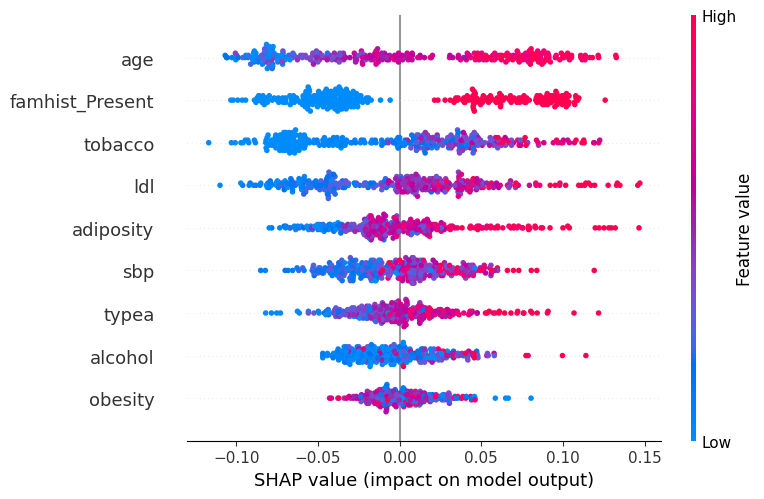

In [30]:
shap.summary_plot( shap_values[:,:,1].squeeze(),
                   X_train.to_numpy(),
                   feature_names = X_features,
                   plot_type = 'dot' )

## 11.3.3 Partial Dependece Plots (PDP)

In [31]:
from sklearn.inspection import PartialDependenceDisplay

### Effect of Age on CHD

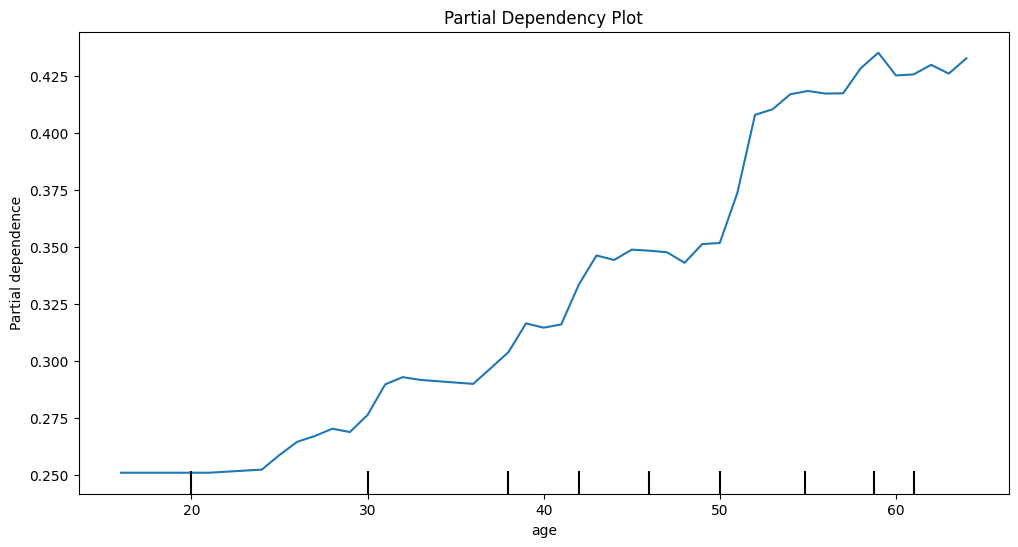

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(rf_clf,
                                        X_test,
                                        features = ['age'],
                                        ax = ax);

### Effect of Tobacco on CHD

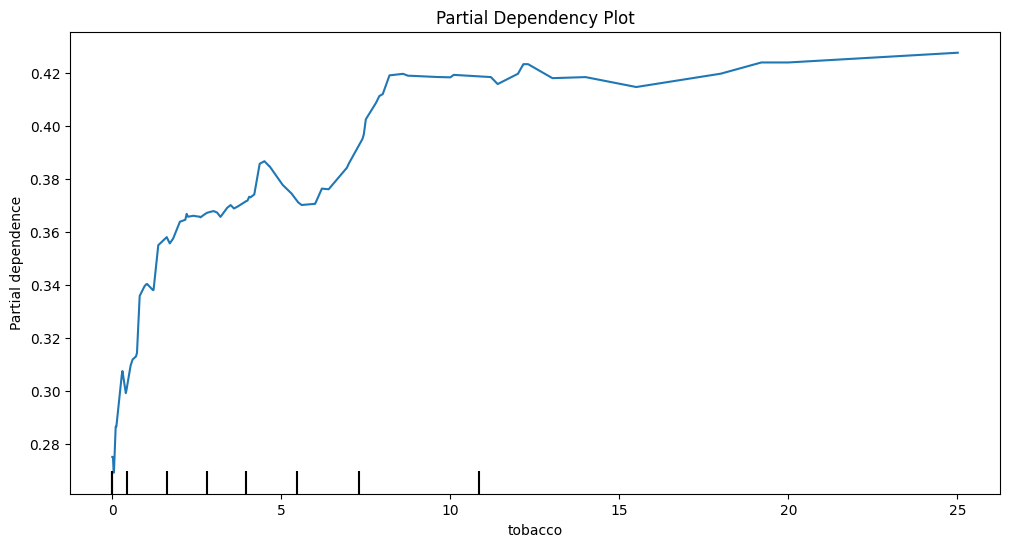

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(rf_clf,
                                        X_test,
                                        features = ['tobacco'],
                                        ax = ax)

## 11.3.4 Individual Conditional Expectations (ICE)

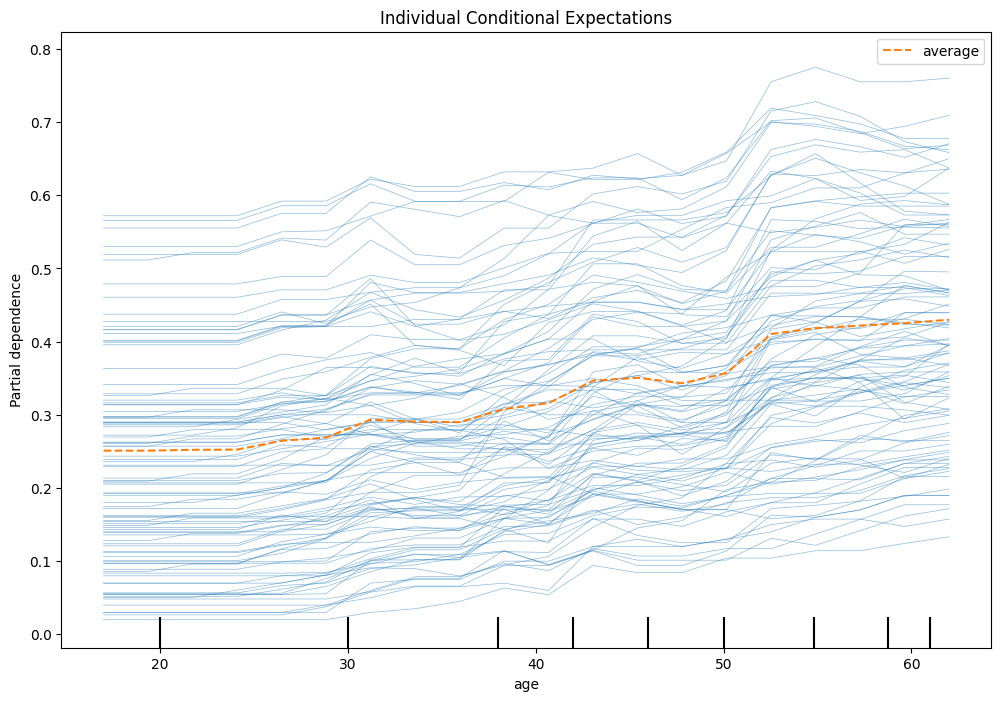

In [43]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Individual Conditional Expectations")

display = PartialDependenceDisplay.from_estimator(
    rf_clf,
    X_test,
    features=["age"],
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "alpha": 1.0},
    ax = ax
)